In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

In [2]:
## 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.show()

## 動作の確認
まずは5量子ビットでグローバーのアルゴリズムを実装し、動作を確認してみる。

全ての状態の重ね合わせ状態$\ket{s}$は状態$\ket{0 \cdots 0}$の全てのビッチにアダマールゲートを作用させることで作れる

### 全ての状態の重ね合わせ状態$| s \rangle = \frac{1}{\sqrt{N}} \sum_x | x \rangle$を用意する。

初期状態$| 0 \cdots 0 \rangle$に対して全ての量子ビットにアダマールゲート$H$をかける。

$$
    (H \otimes \cdots \otimes H)\ket{0 \cdots 0} = \frac{1}{(\sqrt{2})^n}(\ket{0} + \ket{1}) \otimes \cdots \otimes (\ket{0} + \ket{1}) = \ket{s}
$$

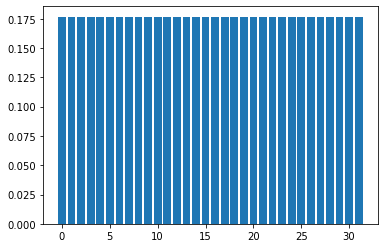

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [4]:
a = np.sqrt(2)
hoge = 1 / a
piyo = hoge ** nqubits
print(hoge)
print(piyo)

0.7071067811865475
0.1767766952966368


### オラクル$U_w$（界に対する反転操作）を作用させる

「入力$\ket{x}$に対して$x$が解なら$-1$をかけて位相を反転し、解でないなら何もしない」という演算を考えることにする。

$$
    U_w = I - 2\sum_{w \in \text{解}} \ket{w}\bra{w} \\
    U_w \ket{x} = \left\{
\begin{array}{ll}
\ket{x} (\text{x is not solution}) \\
 - \ket{x} (\text{x is solution})
\end{array}
\right.
$$
と定義する。入力が解である時にだけ位相を反転させるので、オラクル$U_w$は「解に対する反転操作」と呼ばれる。

次にオラクル$U_w$を作る。ここでは、$\ket{1 \cdots 1}$を解として設定し、$\ket{1 \cdots 1}$のみに位相(-1)をつける演算子を作る。



このような演算子は、「0番目から`nqubits`-1番目までの量子ビットが全て1の場合に`nqubits`番目の量子ビットに$Z$ゲートを作用させる演算子」として実装できる。


In [5]:
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits - 1))
    # i - th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits - 1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [6]:
hoge = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


## $\ket{s}$を対象軸にした反転操作$U_s$を作用させる。

ステップ2では解に対する反転操作を考えたが、ステップ3では全ての状態の重ね合わせ$\ket{s}$を対象じくにした反転操作$U_s$を作用させる。
$$
    U_s = 2 \ket{s}\bra{s} - I
$$

この演算子は、入力状態$\ket{\psi} = a \ket{s} + b \ket{s_{\perp}}$($\ket{s_{\perp}}$は$\ket{s}$に直行するベクトル)に対して、
$$
    U_s \ket{\psi} = a \ket{s} - b \ket{s_{\perp}}
$$
と作用し、$\ket{s_{\perp}}$に比例する部分の位相だけを反転する

同様に、$\ket{s}$を対象軸にした反転$U_s$を作る。
以下の式が成り立つことを使う。

$$
U_s = 2 \ket{s}\bra{s} - I = H^{\otimes n}(2 \ket{0 \cdots 0}\bra{0 \cdots 0} - I)H^{\otimes n}

In [8]:
from re import U


def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits - 1, 2 * np.pi)))
    U_s.add_gate(X(nqubits - 1))
    ## 全てのi-th　qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits - 1))
    for i in range(nqubits - 1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate(CnZ)
    U_s.add_gate(X(nqubits - 1))

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

それでは、$U_s, U_w$を一回だけ作用させて確率分布の変化を見てみる。

全部1の状態（一番右）の確率が少し大きくなっている

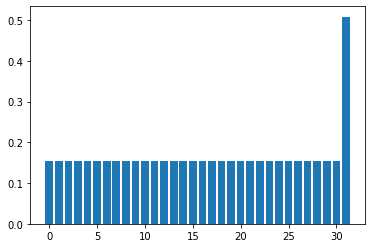

In [9]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_wを作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state, nqubits)